### Importing libraries

In [1]:
# libraries for stats, manipulation
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Importing and Examining Dataset

In [3]:
df = pd.read_csv("seattle-weather.csv")

In [4]:
df.shape

(1461, 6)

There are 1461 rows and 6 columns in our dataset.

In [5]:
df.columns

Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')

In [6]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [7]:
df['weather'].value_counts()

weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

### Data Pre-Processing

#### Missing Values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [9]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

There are no missing values in the dataset.

#### Duplicated Values

In [10]:
df[df.duplicated()]

,date,precipitation,temp_max,temp_min,wind,weather


There are no duplicated values in the dataset.

#### Dropping Unnecessary Columns

In [11]:
df.drop(["date"], axis = 1, inplace = True)

In [12]:
df.columns

Index(['precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')

In [13]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


### Statistical Measures

In [14]:
df.describe(include = 'all')

,precipitation,temp_max,temp_min,wind,weather
count,1461.000000,1461.000000,1461.000000,1461.000000,1461
unique,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,rain
freq,NaN,NaN,NaN,NaN,641
mean,3.029432,16.439083,8.234771,3.241136,NaN
std,6.680194,7.349758,5.023004,1.437825,NaN
min,0.000000,-1.600000,-7.100000,0.400000,NaN
25%,0.000000,10.600000,4.400000,2.200000,NaN
50%,0.000000,15.600000,8.300000,3.000000,NaN
75%,2.800000,22.200000,12.200000,4.000000,NaN


In [15]:
def majority_moments(dataset):    
    """This function calculates the majority moments (mean, median, standard deviation, skewness, and kurtosis) of the numerical columns 
       xin the dataset."""
    numeric_cols = dataset.select_dtypes(include=['number']).columns
    
    moments_df = {
        'Skewness': dataset[numeric_cols].skew(),
        'Kurtosis': dataset[numeric_cols].kurtosis(),
        'Mean': dataset[numeric_cols].mean(),
        'Median': dataset[numeric_cols].median(),
        'Standard Deviation': dataset[numeric_cols].std()
    }
    
    moments_df = pd.DataFrame(moments_df)
    moments_df.index.name = 'Column'
    
    return moments_df

moments_df = majority_moments(df.copy())
print("MAJORITY MOMENTS:")
display(moments_df)

MAJORITY MOMENTS:


,Skewness,Kurtosis,Mean,Median,Standard Deviation
Column,,,,,
precipitation,3.505644,15.522178,3.029432,0.0,6.680194
temp_max,0.280930,-0.690467,16.439083,15.6,7.349758
temp_min,-0.249459,-0.600573,8.234771,8.3,5.023004
wind,0.891668,0.803961,3.241136,3.0,1.437825


Before we go into the numerical results mentioned above, let's define skewness and kurtosis:

**Skewness:** This measure assesses the asymmetry of a variable's distribution. A 0 values means a perfectly symmetrical distribution. A value greater than zero suggests a positively skewed distribution (right-skewed). A value less than zero suggests that the distribution is negatively skewed (left-skewed).

**Kurtosis:** It measures the distribution's shape and compares it to a normal distribution. A value of 0 implies that the distribution has the same peak as a normal distribution. A value greater than zero suggests a peaked distribution with heavier tails compared to a normal distribution. If the values are smaller than zero, it means that the distribution is flatter (lighter tails) than a normal distribution.

Let's now analyze the outcomes of these values in a few columns:

**precipitation:**
* Skewness: 3.505644 - indicates that precipitation data is positively skewed, with a majority of values concentrated towards lower levels and a few extreme values towards higher levels.
* Kurtosis: 15.522178 - indicates heavy-tailedness distribution, suggesting that precipitation data has a higher probability of extreme values compared to a normal distribution.

**temp_max:**
* Skewness: 0.280930 - indicates a slight right skew, suggesting that maximum temperature data is slightly positively skewed, with a slightly longer right tail.
* Kurtosis: -0.690467 - indicates light-tailed distribution, suggesting that maximum temperature data has lighter tails and fewer extreme values compared to a normal distribution.
  
**temp_min:**
* Skewness: -0.249459 - indicates a slight left skew, suggesting that minimum temperature data is slightly negatively skewed, with a slightly longer left tail.
* Kurtosis: -0.600573 - indicates light-tailed distribution, suggesting that minimum temperature data has lighter tails and fewer extreme values compared to a normal distribution.

**wind:**
* Skewness: 0.891668 - indicates a moderate right skew, with a majority of values concentrated towards lower levels and a few extreme values towards higher levels.
* Kurtosis: 0.803961 - indicates slight heavy-tailed distribution, suggesting that wind data has a small probability of extreme values on the right tail.

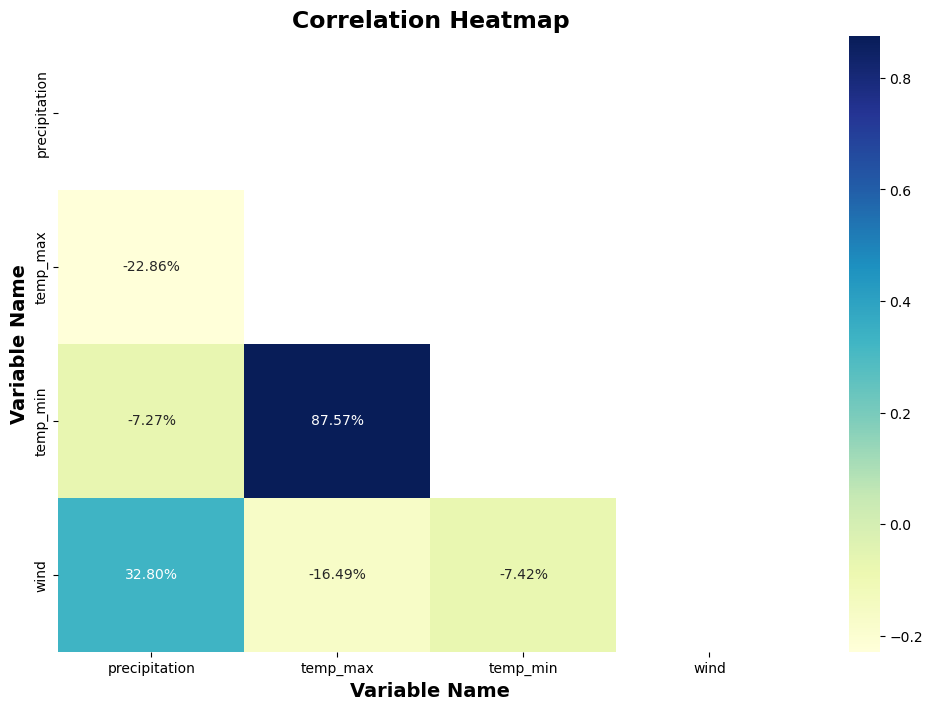

In [16]:
def heatmap_of_correlation(dataset):
    """Plots the correlation heatmap of all numerical columns in the dataset"""
    numeric_cols = dataset.select_dtypes(include=['number']).columns
    corr = dataset[numeric_cols].corr()
    
    # avoid redundancy by getting the lower portion of the heatmap only
    matrix = np.triu(corr)
    
    # build the heatmap
    plt.figure(figsize = (12, 8))
    sns.heatmap(corr, annot=True, fmt=".2%", cmap="YlGnBu", mask=matrix)     # fmt=".2%" to display percentages
    plt.title("Correlation Heatmap", fontsize=17, fontweight='bold')
    plt.xlabel("Variable Name", fontsize=14, fontweight='bold')
    plt.ylabel("Variable Name", fontsize=14, fontweight='bold')
    plt.savefig('1.Correlation_Heatmap_Plot.png', dpi=300)
    plt.show()

heatmap_of_correlation(df)

In [17]:
numeric_cols = df.select_dtypes(include=['number']).columns
corr = df[numeric_cols].corr()
corr

,precipitation,temp_max,temp_min,wind
precipitation,1.000000,-0.228555,-0.072684,0.328045
temp_max,-0.228555,1.000000,0.875687,-0.164857
temp_min,-0.072684,0.875687,1.000000,-0.074185
wind,0.328045,-0.164857,-0.074185,1.000000


The correlation measure, often known as Pearson's measure, is a statistical measure that determines the strength of a direct association between variables on a scale of -1 to 1.
* A value of 1 implies a complete positive correlatio.
 * A value of -1 shows a perfect negative correlatio.
*  A value of zero implies no association between the variables.    

In our dataset, there's a very goodassociationn between the "temp_max" and "temp_min" variables.

### Data Visualization and EDA

In [18]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


#### Distribution of Target Variable: Weather

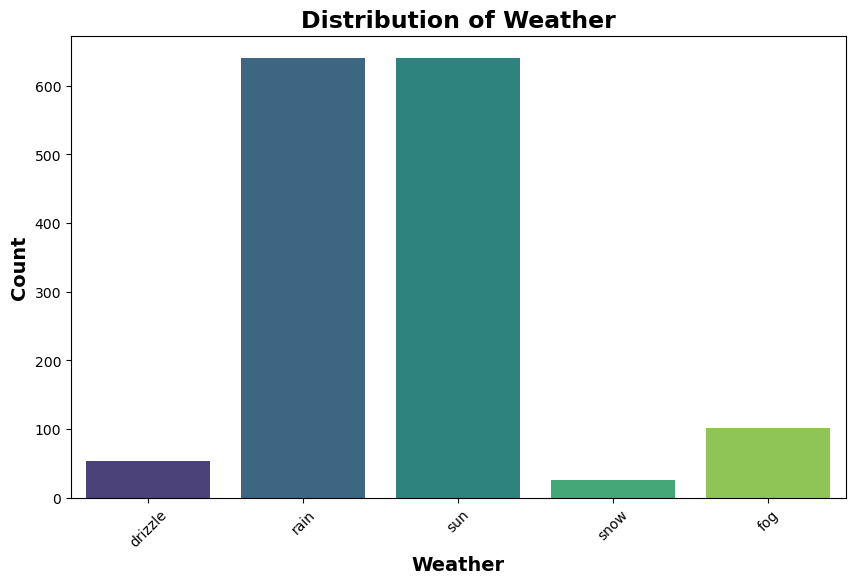

In [19]:
def visualize_weather_distribution(dataset):
    """Visualizes the distribution of the 'weather' column in the dataset."""
    # set up figure and axis
    plt.figure(figsize=(10, 6))
    
    # plot distribution of weather variable
    sns.countplot(x = 'weather', data = dataset, palette='viridis')
    
    # set title and labels
    plt.title('Distribution of Weather', fontsize = 17, fontweight = 'bold')
    plt.xlabel('Weather', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
    plt.xticks(rotation=45)
    plt.savefig("2.Weather_Distribution.png", dpi = 300)
    plt.show()

visualize_weather_distribution(df)

#### Categorical Plots

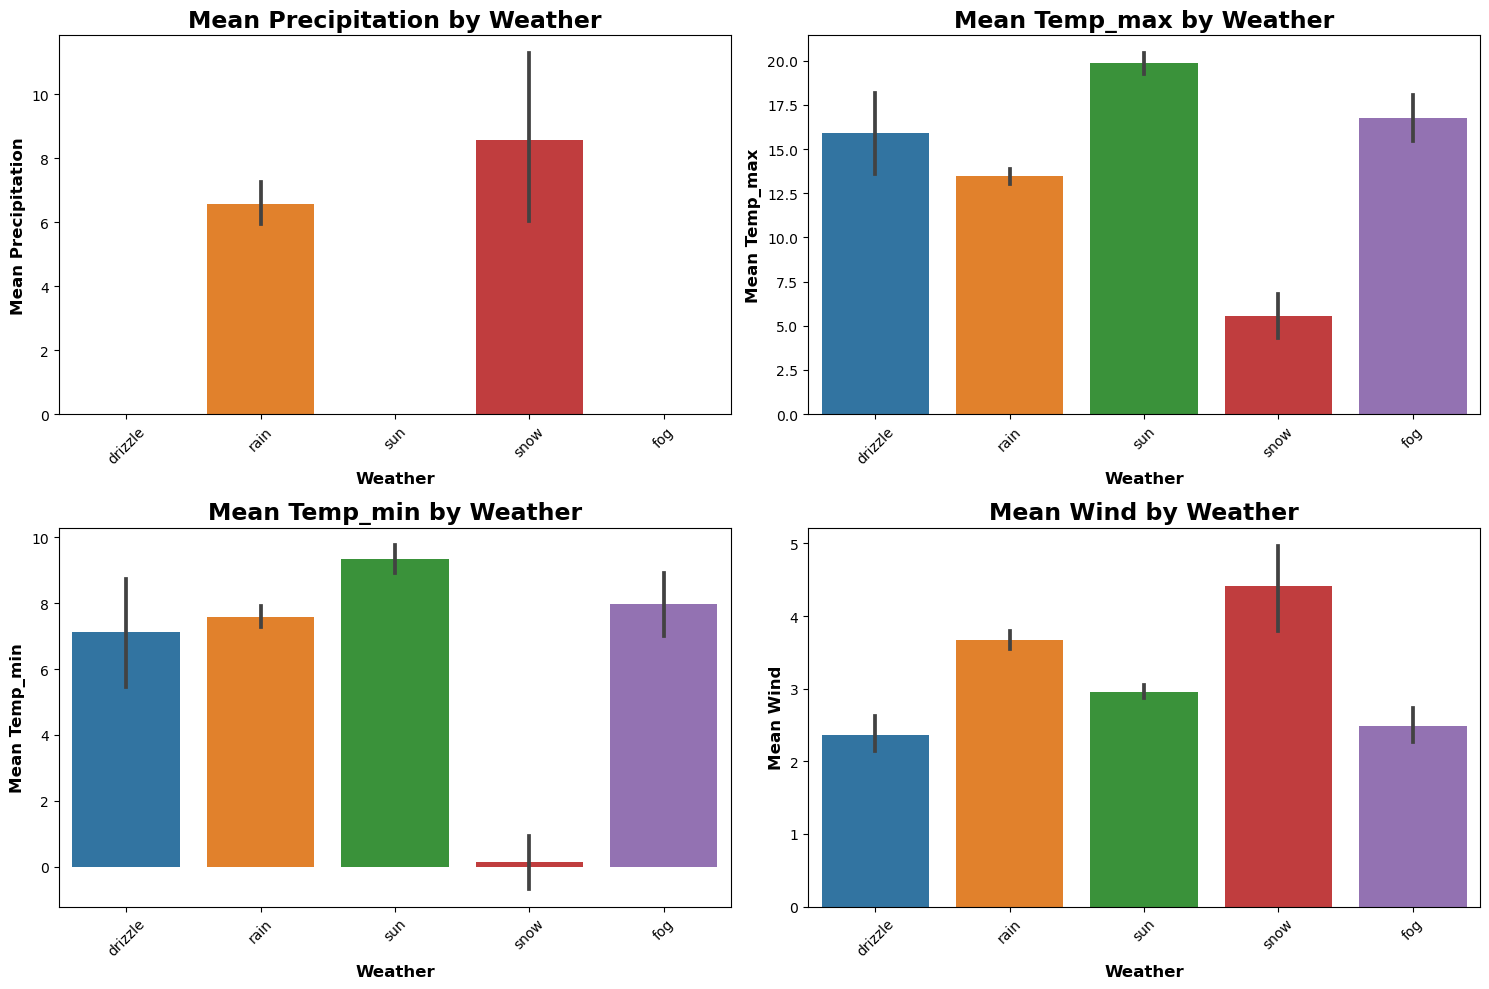

In [20]:
def plot_mean_by_weather(dataset):
    """Plots the mean values of dataset columns categorized by the 'weather' column."""
    columns = ["precipitation",	"temp_max",	"temp_min",	"wind"]
    
    # calculate the number of rows needed
    num_cols = len(columns)
    num_plots_per_row = 2
    num_rows = (num_cols + 1) // num_plots_per_row
    
    # set up figure and axis
    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        # plot mean values hued by weather column
        sns.barplot(data = dataset, x = 'weather', y = column, ax=axes[i])
        
        # set title and labels
        axes[i].set_title(f'Mean {column.capitalize()} by Weather', fontsize=17, fontweight='bold')
        axes[i].set_xlabel('Weather', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(f'Mean {column.capitalize()}', fontsize=12, fontweight='bold')
        axes[i].tick_params(axis='x', rotation=45)
    
    # remove any empty subplot
    for j in range(len(dataset.columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig("3.Mean_by_Weather.png", dpi = 300)
    plt.show()

plot_mean_by_weather(df)

#### Scatter Plot Relationship

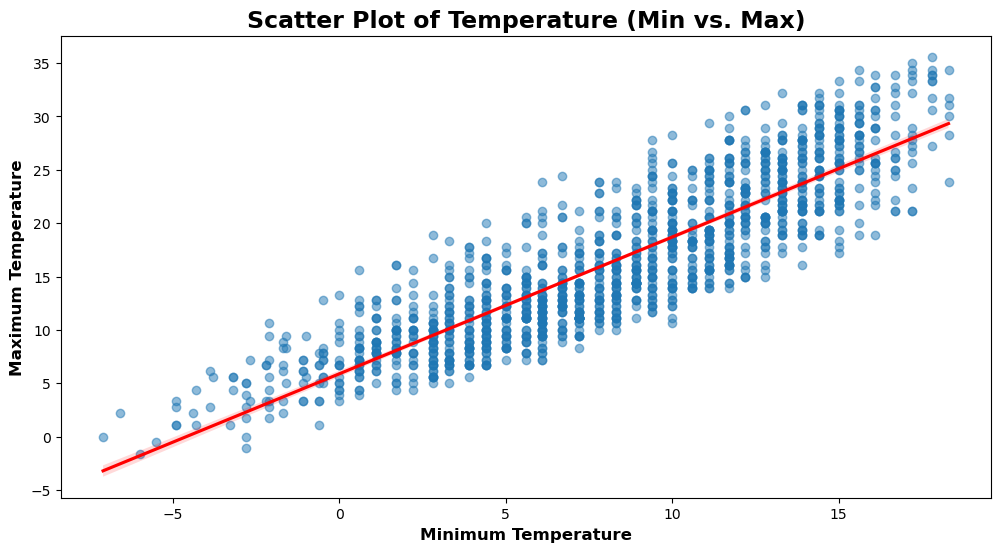

In [21]:
def scatter_temp_min_max(dataset):
    """Creates a scatter plot between 'temp_min' and 'temp_max' variables."""
    # set up figure and axis
    plt.figure(figsize=(12, 6))
    
    # plot scatter plot
    plt.scatter(x = dataset['temp_min'], y = dataset['temp_max'], alpha=0.5)
    sns.regplot(x = 'temp_min', y = 'temp_max', scatter = False, color = 'red', data = dataset)
    
    # set title and labels
    plt.title('Scatter Plot of Temperature (Min vs. Max)', fontsize=17, fontweight='bold')
    plt.xlabel('Minimum Temperature', fontsize=12, fontweight='bold')
    plt.ylabel('Maximum Temperature', fontsize=12, fontweight='bold')
    plt.savefig("4.Temp_Min_Max_Scatter.png", dpi = 300)
    plt.show()

scatter_temp_min_max(df)

### Model Trainings and Evaluation

#### Create Numerical Mapping for Target Variable

In [22]:
weather_mapping = {1: "rain", 2: "sun", 3: "fog", 4: "drizzle", 5: "snow"}

def weather_to_number(weather):
    for num, w in weather_mapping.items():
        if w == weather:
            return num
    return None

# apply the function on the weather column
def apply_weather_to_number(column):
    return column.apply(weather_to_number)

df['weather_numeric'] = apply_weather_to_number(df['weather'])
df.head()

,precipitation,temp_max,temp_min,wind,weather,weather_numeric
0,0.0,12.8,5.0,4.7,drizzle,4
1,10.9,10.6,2.8,4.5,rain,1
2,0.8,11.7,7.2,2.3,rain,1
3,20.3,12.2,5.6,4.7,rain,1
4,1.3,8.9,2.8,6.1,rain,1


#### Selecting Optimal Number of Clusters using the Elbow Method

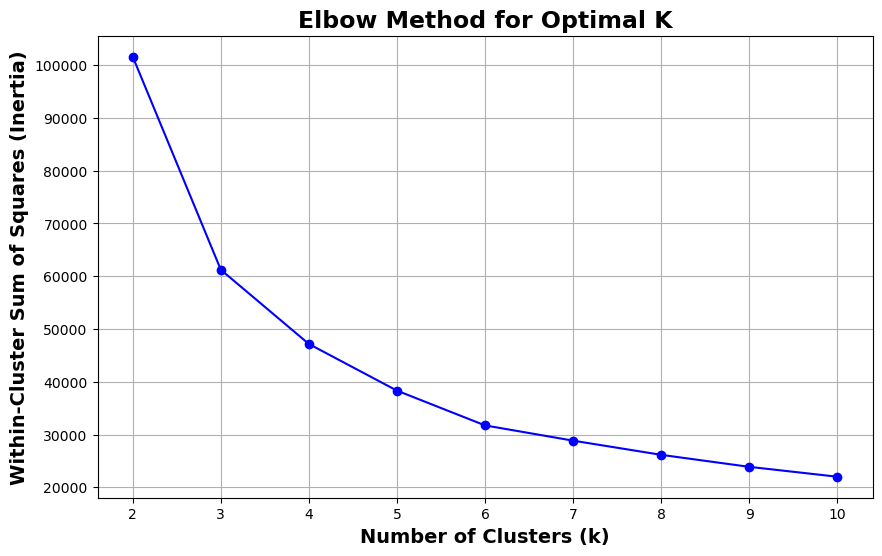

In [23]:
def optimal_clusters_elbow_method(dataset):
    """This function calculates the ideal number of clusters for the K-Means clustering algorithm and returns the tested k-values 
       and model inertia values for each cluster (K)."""
    # drop the categorical weather column
    dataset = dataset.drop('weather', axis = 1)
    
    # initialize lists to store inertia values
    inertia_values = []
    
    # test different values of k (clusters) 
    k_values = range(2, 11)  
    for k in k_values:
        # create KMeans clustering model
        kmeans = KMeans(n_clusters = k, init='k-means++', n_init=10, max_iter=300, random_state=42)
        kmeans.fit(dataset)
    
        # append the inertia value to the list
        inertia_values.append(kmeans.inertia_)

    return k_values, inertia_values
    
k_values, inertia_values = optimal_clusters_elbow_method(df)

# plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)', fontsize=14, fontweight='bold')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=14, fontweight='bold')
plt.title('Elbow Method for Optimal K', fontsize=17, fontweight='bold')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('5.Optimal_Clusters_Elbow_Method.png', dpi=300)
plt.show()

The optimal number of clusters in this case seems to be 3 as after 3, the line is starting to become straight.

#### K-Means Modeling

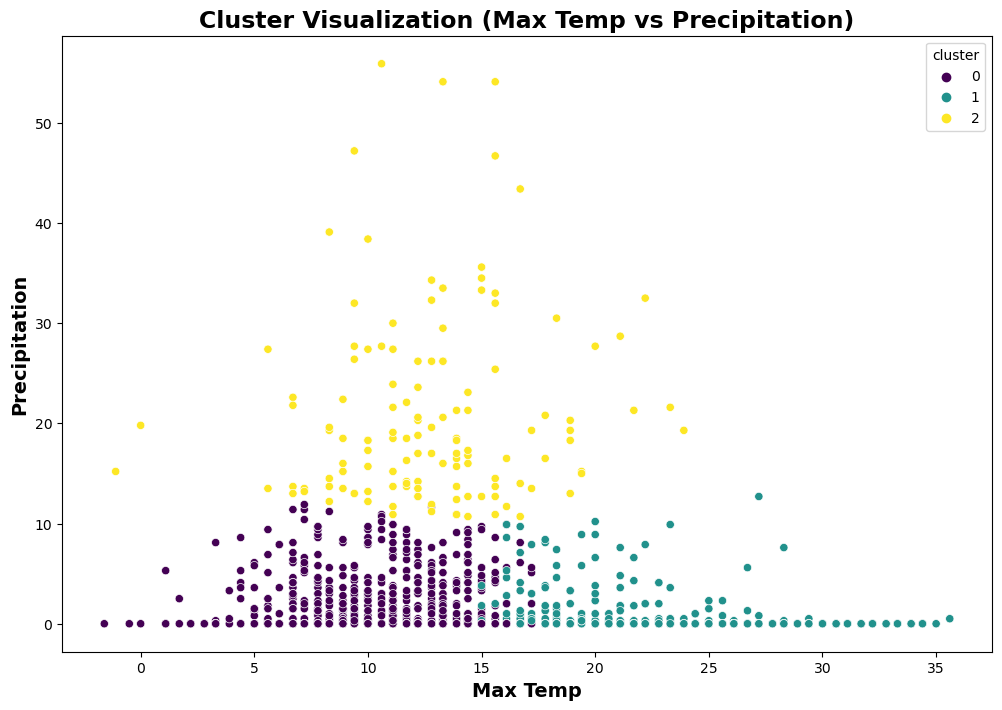

In [24]:
def kmeans_clustering(dataset, clusters = 3):
    """This function creates a K-Means model using the specified dataset and cluster number and returns the trained model."""
    # drop the categorical weather column
    dataset = dataset.drop('weather', axis = 1)
    
    # instantiate the KMeans model
    kmeans_model = KMeans(n_clusters = clusters)
    
    # fit the model to the scaled data
    kmeans_model.fit(dataset)

    return kmeans_model

kmeans_model = kmeans_clustering(df)

# add a cluster column in the reduced data
df['cluster'] = kmeans_model.labels_

# plot the clusters made by the K-Means model
plt.figure(figsize = (12, 8))
sns.scatterplot(x = 'temp_max', y = 'precipitation', hue = 'cluster', data = df, palette='viridis')
plt.title('Cluster Visualization (Max Temp vs Precipitation)', fontsize = 17, fontweight = 'bold')
plt.xlabel('Max Temp', fontsize=14, fontweight='bold')
plt.ylabel('Precipitation', fontsize=14, fontweight='bold')
plt.savefig("6.Cluster_Visualization_1.png")
plt.show()

In [25]:
# example new data point(s) for prediction
new_data_points = pd.DataFrame({'precipitation': [1, 0.3], 'temp_max': [20, 25], 'temp_min': [10, 15], 'wind': [3, 4], 
                                'weather_numeric': [3, 1]})

# use the trained K-means model to predict cluster labels for the new data points
predicted_clusters = kmeans_model.predict(new_data_points)
for i, cluster_label in enumerate(predicted_clusters):
    print(f"Predicted Cluster for New Data Point {i + 1}: {cluster_label}")

Predicted Cluster for New Data Point 1: 1
Predicted Cluster for New Data Point 2: 1


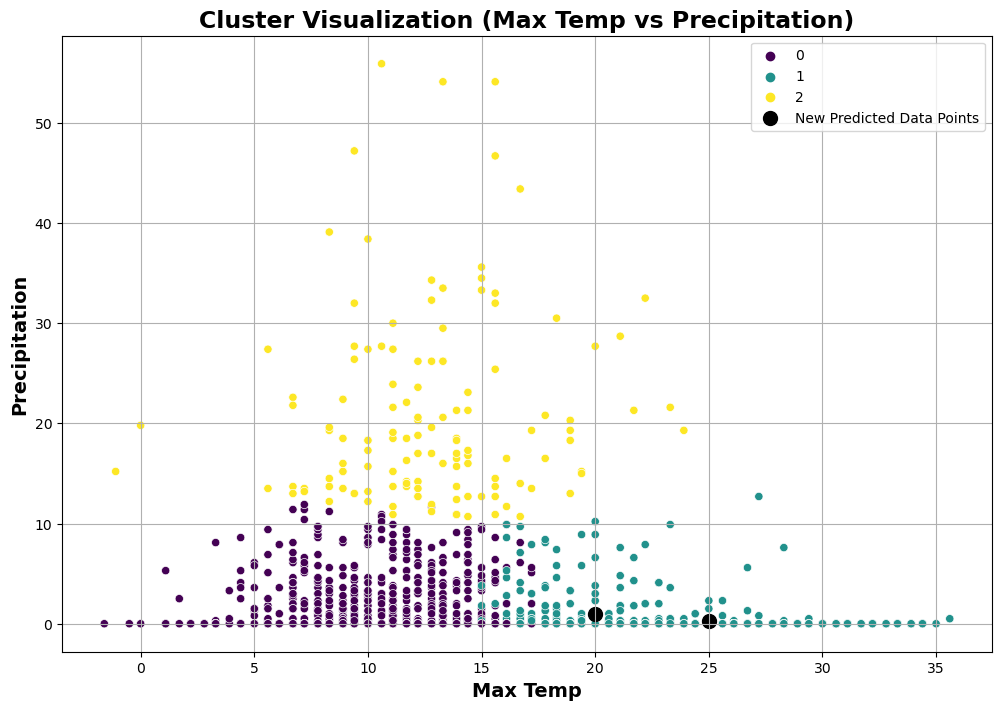

In [26]:
# plot the clusters made by the K-Means model
plt.figure(figsize = (12, 8))
sns.scatterplot(x = 'temp_max', y = 'precipitation', hue = 'cluster', data = df, palette='viridis')

# plot the new predicted data points
plt.scatter(new_data_points['temp_max'], new_data_points['precipitation'], marker='o', s=100, c='black', label = 'New Predicted Data Points')

plt.title('Cluster Visualization (Max Temp vs Precipitation)', fontsize = 17, fontweight = 'bold')
plt.xlabel('Max Temp', fontsize=14, fontweight='bold')
plt.ylabel('Precipitation', fontsize=14, fontweight='bold')
plt.savefig("7.Cluster_Visualization_2.png", dpi = 300)
plt.legend()
plt.grid(True)
plt.show()

#### Fitting Predictions
For linear regression, since weather is a categorical variable, we will consider the target variable as Maximum Temperature.

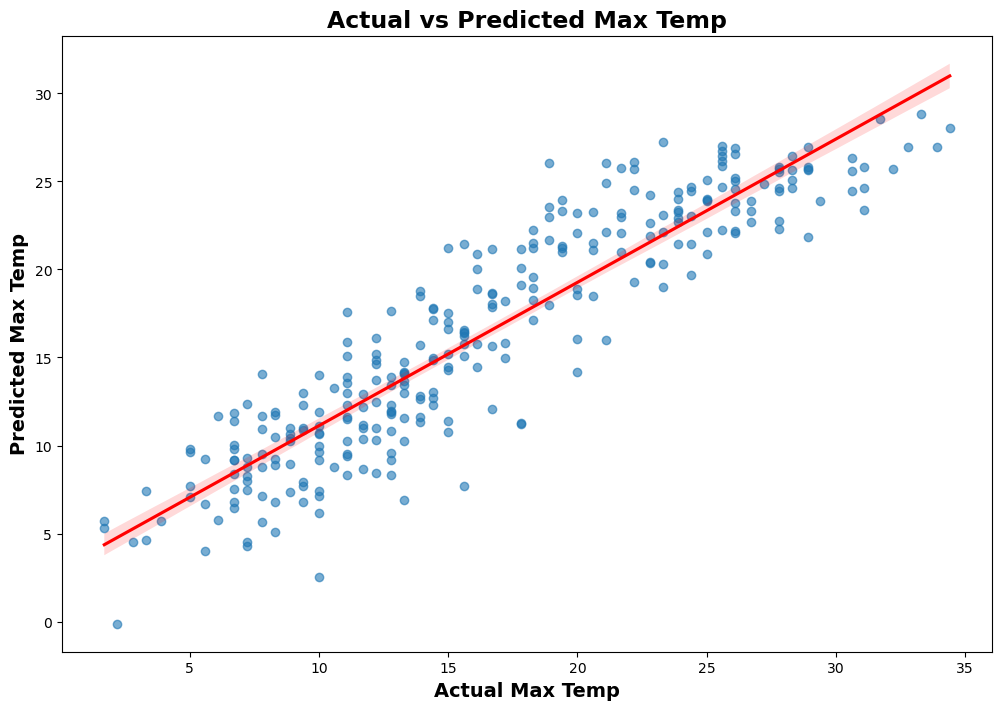

In [27]:
def lr_fitting_predictions(X_train, y_train, X_test):    
    """This function takes in training and testing data and applies a linear regression model to it. 
       The trained model is returned together with test data predictions."""
    # initialize Linear Regression model
    LR_model = LinearRegression()
    
    # fit the model on the training data
    LR_model.fit(X_train, y_train)

    # predict on the test data
    y_pred = LR_model.predict(X_test)

    return LR_model, y_pred

# separate features (X) and target variable (y)
X = df.drop(['weather', 'temp_max'], axis=1)
y = df['temp_max']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LR_model, y_pred = lr_fitting_predictions(X_train, y_train, X_test)

# plot the predicted vs actual values with confidence intervals
plt.figure(figsize=(12, 8))
sns.regplot(x = y_test, y = y_pred, scatter_kws={"alpha":0.6}, line_kws={"color":"red", "linestyle":"-"}, ci=95)
plt.title('Actual vs Predicted Max Temp', fontsize=17, fontweight='bold')
plt.xlabel('Actual Max Temp', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Max Temp', fontsize=14, fontweight='bold')
plt.savefig('8.Linear_Regression_on_Max_Temp.png', dpi=300)
plt.show()

#### Linear Regression Evaluation

In [28]:
def evaluate_lr_fitting_predictions(LR_model, y_test, y_pred):
    """This function uses the regression model, test data, and projected data to generate performance metrics such as model 
       coefficients, intercept, R-squared score, root mean squared error, and mean absolute error."""
    # calculate the model's coefficients and intercept
    coefficients = LR_model.coef_
    intercept = LR_model.intercept_
    print(f'Coefficients {coefficients}')
    print(f'Intercept: {intercept}')
    
    # calculate r-squared score (accuracy)
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    # calculate root mean squared error
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(f'RMSE: {rmse}')
    
    # calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print(f'MAE {mae}')

evaluate_lr_fitting_predictions(LR_model, y_test, y_pred)

Coefficients [-0.25854239  1.09306341 -0.11833289  0.76266533  2.30770459]
Intercept: 5.825421348714462
R2: 0.8394834775061962
RMSE: 3.022361018294704
MAE 2.453914269153061
